In [1]:
import torch
import torchvision
import numpy as np 
import torch.nn as nn
from torchvision import datasets
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
import matplotlib.pyplot as plt 

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cpu'

## Importing Data

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
raw_train_dataset = []
raw_train_label = []
raw_test_dataset = []
raw_test_label = []

for files in os.listdir('./data/Cifar10'):
    if files.find('data') == 0:
       #print(type(files))
       data = unpickle('./data/Cifar10/'+files)
       #print(type(data[b'data']))
       raw_train_dataset.append(data[b'data'])
       raw_train_label.append(data[b'labels'])
    elif files.find('test') == 0:
        data_test = unpickle('./data/Cifar10/'+files)
        raw_test_dataset.append(data_test[b'data'])
        raw_test_label.append(data_test[b'labels'])

dataset_train = np.concatenate((raw_train_dataset), axis=0) #numpy array with [50000, 3072] size
label_train = np.concatenate(raw_train_label, axis=0)
dataset_test = np.concatenate((raw_test_dataset), axis=0) #numpy array with [10000, 3072] size
label_test = np.concatenate(raw_test_label, axis=0)

In [5]:
print((dataset_train).shape, type(dataset_train), dataset_train.dtype)
print((dataset_test).shape)
print((label_train).shape, type(label_train), label_train.dtype)
print((label_test).shape, type(label_test), label_test.dtype)
#torch.from_numpy(label_train).shape

(50000, 3072) <class 'numpy.ndarray'> uint8
(10000, 3072)
(50000,) <class 'numpy.ndarray'> int32
(10000,) <class 'numpy.ndarray'> int32


In [6]:
class cifar_data(Dataset):
    def __init__(self, train=True):
        super(cifar_data,self).__init__()

        if train:
            self.data = torch.from_numpy(dataset_train).to(dtype= torch.float32, device=device)
            self.label = torch.from_numpy(label_train).to(dtype= torch.float32, device= device)
        else:
            self.data = torch.from_numpy(dataset_test).to(dtype= torch.float32, device=device)
            self.label = torch.from_numpy(label_test).to(dtype= torch.float32, device= device)

        self.transform = transforms.Compose([transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        
    
    def __getitem__(self,index):
        sample_img = self.transform(self.data[index].view(3,32,32))
        return (sample_img, self.label[index])

    def __len__(self):
        return len(self.data)

    def obj_class(self,index):
        return self.classes[self.label[index].to(torch.int).item()] 



This sample is: cat



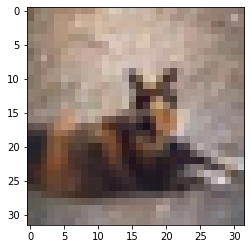

In [8]:
# Samples of Dataset
my_cifar_train = cifar_data(train=True)
my_cifar_test = cifar_data(train=False)

num_sample = torch.randint(10000,(1,))
img=my_cifar_test[num_sample][0]
print(f'\nThis sample is: {my_cifar_test.obj_class(num_sample)}\n')
img = img / 2 + 0.5 # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0))/255)
plt.show()

In [9]:
# Data Loader
train_loader = DataLoader(dataset= my_cifar_train, batch_size= 1000, shuffle= True)
sample_train = next(iter(train_loader))
print(sample_train[0].shape)

test_loader = DataLoader(dataset= my_cifar_test, batch_size= 500, shuffle= False)
sample_test = next(iter(test_loader))
print(sample_test[0].shape)

torch.Size([1000, 3, 32, 32])
torch.Size([500, 3, 32, 32])


In [10]:
'''
you can use this formula [(W−K+2P)/S]+1.

W is the input volume - in your case 32
K is the Kernel size - in your case 5
P is the padding - in your case 0
S is the stride - which is 1.
'''

'\nyou can use this formula [(W−K+2P)/S]+1.\n\nW is the input volume - in your case 32\nK is the Kernel size - in your case 5\nP is the padding - in your case 0\nS is the stride - which is 1.\n'

In [11]:
# CNN Network
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        # output width c1 : [(32-5+2*0)/1]+1 = 28
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # output width first pooling : 14
        self.conv2 = nn.Conv2d(6, 16, 5)
        # output width c2 : [(14-5+0)/1]+1 = 10 > after second pooling : 5
        self.fc1 = nn.Linear(16*5*5, 200)
        self.fc2 = nn.Linear(200, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.fc1(x.view(-1, 16*5*5)))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
net = network()    

## Network Features

In [12]:
print(net)

network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


In [32]:
print(net.state_dict().keys())

print(net.state_dict()['conv1.weight'].shape)

torch.save(net.state_dict(), './cnn_net.pt') # save network state
New_net = network() # make a new Raw network
stat_dict = torch.load('./cnn_net.pt') # Load saved parameters
New_net.load_state_dict(stat_dict) # Import parameters to New network
print('\n',net.state_dict()['fc3.bias'])
print(New_net.state_dict()['fc3.bias'])

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])
torch.Size([6, 3, 5, 5])

 tensor([-0.0802, -0.0429,  0.0231, -0.0343, -0.0738,  0.0498, -0.0542, -0.0786,
         0.0244, -0.1067])
tensor([-0.0802, -0.0429,  0.0231, -0.0343, -0.0738,  0.0498, -0.0542, -0.0786,
         0.0244, -0.1067])


In [36]:
net.parameters

<bound method Module.parameters of network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)>

In [39]:
for p in net.parameters():
    print(p.shape)

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([200, 400])
torch.Size([200])
torch.Size([80, 200])
torch.Size([80])
torch.Size([10, 80])
torch.Size([10])


## Network Training

In [26]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr = 0.001, momentum= 0.9)
# learning rate schedular
#schedular = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1) # every 'step_size' epoch, multiply lr by gamma

In [73]:
# Training Loop
num_epoch = 1
num_correct = 0

for epoch in range(num_epoch):

    for i, (img, label) in enumerate(train_loader):

        pred = net(img)

        loss = loss_fn(pred, label.to(torch.long))

        opt.zero_grad()
        loss.backward()
        opt.step()

        if i%10 == 0: print(f'Epoch: {epoch+1}/{num_epoch} , Iteration: {i} , Loss: {loss.item(): .4f}')
        
        # Test data result at the End of each epoch
        if i == 49:
            with torch.no_grad():
                for j , (img_test, label_test) in enumerate(test_loader):
                    pred_test = net(img_test)
                    num_correct += len(torch.where(pred_test.max(axis=1).indices == label_test.to(torch.long))[0])
                print(f'Test data accuracy for epoch {epoch+1} is: {num_correct}/{len(my_cifar_test)}')


Epoch: 1/1 , Iteration: 0 , Loss:  2.3027
Epoch: 1/1 , Iteration: 10 , Loss:  2.3022
Epoch: 1/1 , Iteration: 20 , Loss:  2.2992
Epoch: 1/1 , Iteration: 30 , Loss:  2.3032
Epoch: 1/1 , Iteration: 40 , Loss:  2.3003
Test data accuracy: 1121/20


## Code example from : 
https://github.com/python-engineer/pytorchTutorial/blob/master/15_transfer_learning.py

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model